# import os
from pathlib import Path
import zipfile
import tempfile
import shutil
import logging
import xarray as xr

class ERA5FileHandler:
    def __init__(self, data_dir=r'G:\workflow0822\era5_full_data-20241216T113828Z-001\era5_full_data'):
        """初始化文件处理器"""
        self.data_dir = Path(data_dir)
        self.temp_dir = Path(tempfile.mkdtemp())
        self.setup_logging()
        
    def setup_logging(self):
        """设置日志"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger('ERA5FileHandler')
        
    def process_file(self, file_path):
        """处理单个文件"""
        file_path = Path(file_path)
        self.logger.info(f"处理文件: {file_path.name}")
        
        try:
            # 检查是否为ZIP文件
            if self.is_zip_file(file_path):
                self.logger.info(f"{file_path.name} 是ZIP文件，开始解压...")
                extracted_file = self.extract_zip(file_path)
                if extracted_file:
                    self.logger.info(f"成功解压到: {extracted_file}")
                    return extracted_file
            else:
                self.logger.info(f"{file_path.name} 不是ZIP文件")
                return file_path
                
        except Exception as e:
            self.logger.error(f"处理文件时出错: {str(e)}")
            return None
            
    def is_zip_file(self, file_path):
        """检查是否为ZIP文件"""
        try:
            with open(file_path, 'rb') as f:
                return f.read(4) == b'PK\x03\x04'
        except Exception as e:
            self.logger.error(f"检查文件格式失败: {str(e)}")
            return False
            
    def extract_zip(self, zip_path):
        """解压ZIP文件"""
        try:
            # 创建临时目录用于解压
            extract_dir = self.temp_dir / zip_path.stem
            extract_dir.mkdir(parents=True, exist_ok=True)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # 获取ZIP文件中的内容列表
                file_list = zip_ref.namelist()
                self.logger.info(f"ZIP文件内容: {file_list}")
                
                # 解压文件
                zip_ref.extractall(extract_dir)
                
                # 查找.nc文件
                nc_files = list(extract_dir.glob('*.nc'))
                if nc_files:
                    return nc_files[0]
                else:
                    self.logger.error("ZIP文件中未找到.nc文件")
                    return None
                    
        except Exception as e:
            self.logger.error(f"解压文件失败: {str(e)}")
            return None
            
    def process_all_files(self):
        """处理目录中的所有文件"""
        processed_files = []
        
        try:
            # 获取所有.nc文件
            nc_files = list(self.data_dir.glob('*.nc'))
            self.logger.info(f"找到 {len(nc_files)} 个.nc文件")
            
            for file_path in nc_files:
                processed_file = self.process_file(file_path)
                if processed_file:
                    processed_files.append(processed_file)
                    
            return processed_files
            
        except Exception as e:
            self.logger.error(f"处理文件时出错: {str(e)}")
            return []
            
    def cleanup(self):
        """清理临时文件"""
        try:
            if hasattr(self, 'temp_dir') and self.temp_dir.exists():
                shutil.rmtree(self.temp_dir)
                self.logger.info("清理临时文件完成")
        except Exception as e:
            self.logger.error(f"清理临时文件失败: {str(e)}")
        finally:
            # 确保temp_dir属性被删除
            if hasattr(self, 'temp_dir'):
                delattr(self, 'temp_dir')
    
    def __del__(self):
        """析构函数，确保清理临时文件"""
        if hasattr(self, 'temp_dir'):
            self.cleanup()

def main():
    handler = None
    try:
        # 创建处理器实例
        handler = ERA5FileHandler()
        
        # 处理所有文件
        processed_files = handler.process_all_files()
        
        # 使用上下文管理器处理数据集
        for file_path in processed_files:
            try:
                with xr.open_dataset(file_path) as ds:
                    print(f"\n成功读取文件 {file_path.name}:")
                    print("变量:", list(ds.data_vars))
                    print("维度:", ds.dims)
            except Exception as e:
                print(f"读取文件 {file_path.name} 失败: {str(e)}")
    
    except Exception as e:
        print(f"程序执行出错: {str(e)}")
        
    finally:
        # 确保清理临时文件
        if handler is not None:
            handler.cleanup()

if __name__ == "__main__":
    main()

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import tempfile
import zipfile
import shutil
import re
from datetime import datetime

class ERA5CompleteProcessor:
    def __init__(self, data_dir=r'G:\workflow0822\era5_full_data-20241216T113828Z-001\era5_full_data'):
        """初始化完整数据处理器"""
        self.data_dir = Path(data_dir)
        self.temp_dir = Path(tempfile.mkdtemp())
        self.setup_logging()
        
        # 定义变量列表
        self.variable_groups = {
            'single_level': [
                '2m_temperature', 'total_precipitation', 
                'mean_sea_level_pressure', '10m_u_component_of_wind',
                '10m_v_component_of_wind', 'total_column_water_vapour',
                'boundary_layer_height', 'surface_pressure',
                'sea_surface_temperature'
            ],
            'pressure_level': [
                'geopotential', 'relative_humidity'
            ]
        }

    def setup_logging(self):
        """设置日志记录"""
        log_file = self.data_dir / 'era5_processing.log'
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger('ERA5CompleteProcessor')

    def extract_date_from_filename(self, filename):
        """从文件名提取年月信息"""
        match = re.search(r'(\d{4})_(\d{2})', filename)
        if match:
            return int(match.group(1)), int(match.group(2))
        return None, None

    def process_single_file(self, file_path, data_type='single'):
        """处理单个文件（支持ZIP和直接NC格式）"""
        try:
            # 检查是否为ZIP文件
            is_zip = False
            with open(file_path, 'rb') as f:
                is_zip = f.read(4) == b'PK\x03\x04'
            
            if is_zip:
                self.logger.info(f"{file_path.name} 是ZIP文件，进行解压...")
                # ZIP文件处理
                extract_dir = self.temp_dir / file_path.stem
                extract_dir.mkdir(parents=True, exist_ok=True)
                
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                    
                # 读取instant和accum数据
                instant_file = extract_dir / 'data_stream-oper_stepType-instant.nc'
                accum_file = extract_dir / 'data_stream-oper_stepType-accum.nc'
                
                datasets = []
                if instant_file.exists():
                    ds_instant = xr.open_dataset(instant_file)
                    datasets.append(ds_instant)
                    
                if accum_file.exists():
                    ds_accum = xr.open_dataset(accum_file)
                    datasets.append(ds_accum)
            else:
                # 直接读取NC文件
                self.logger.info(f"{file_path.name} 是NC文件，直接读取...")
                ds = xr.open_dataset(file_path)
                datasets = [ds]
            
            if not datasets:
                raise FileNotFoundError("未找到有效的数据文件")
                
            # 合并数据集
            ds_merged = xr.merge(datasets) if len(datasets) > 1 else datasets[0]
            
            # 统一时间维度名称
            if 'time' in ds_merged.dims:
                ds_merged = ds_merged.rename({'time': 'valid_time'})
            
            # 移除可能导致问题的变量
            for var in ['number', 'expver']:
                if var in ds_merged:
                    ds_merged = ds_merged.drop(var)
            
            return ds_merged
            
        except Exception as e:
            self.logger.error(f"处理文件 {file_path.name} 失败: {str(e)}")
            return None

    def process_data_type(self, data_type='single'):
        """处理指定类型（单层/压力层）的所有数据"""
        try:
            pattern = f"era5_{data_type}_*.nc"
            files = sorted(self.data_dir.glob(pattern))
            self.logger.info(f"找到 {len(files)} 个 {data_type} 类型文件")
            
            all_datasets = []
            years_processed = set()
            
            for file_path in files:
                year, month = self.extract_date_from_filename(file_path.name)
                if year:
                    self.logger.info(f"处理 {year}年{month}月 的数据")
                    ds = self.process_single_file(file_path)
                    if ds is not None:
                        all_datasets.append(ds)
                        years_processed.add(year)
                        
            if all_datasets:
                # 合并所有数据
                ds_combined = xr.concat(all_datasets, dim='valid_time')
                ds_combined = ds_combined.sortby('valid_time')
                
                # 添加时间信息
                times = pd.to_datetime(ds_combined.valid_time.values)
                ds_combined['year'] = ('valid_time', times.year)
                ds_combined['month'] = ('valid_time', times.month)
                
                self.logger.info(f"处理了 {len(years_processed)} 年的数据，年份范围：{min(years_processed)}-{max(years_processed)}")
                return ds_combined
            else:
                self.logger.error(f"没有成功处理的 {data_type} 数据")
                return None
                
        except Exception as e:
            self.logger.error(f"处理 {data_type} 数据失败: {str(e)}")
            return None

    def process_all_data(self):
        """处理所有数据"""
        try:
            # 处理单层数据
            self.logger.info("开始处理单层数据...")
            ds_single = self.process_data_type('single')
            
            # 处理压力层数据
            self.logger.info("开始处理压力层数据...")
            ds_pressure = self.process_data_type('pressure')
            
            if ds_single is None and ds_pressure is None:
                raise ValueError("单层和压力层数据处理都失败")
                
            # 合并单层和压力层数据
            if ds_single is not None and ds_pressure is not None:
                final_ds = xr.merge([ds_single, ds_pressure])
            else:
                final_ds = ds_single if ds_single is not None else ds_pressure
                
            return final_ds
            
        except Exception as e:
            self.logger.error(f"处理所有数据失败: {str(e)}")
            return None
        finally:
            self.cleanup()

    def save_complete_dataset(self, ds, output_file='complete_era5_data.nc'):
        """保存完整的数据集"""
        if ds is not None:
            try:
                output_path = self.data_dir / output_file
                self.logger.info(f"保存数据到: {output_path}")
                
                # 移除特殊变量
                for var in ['number', 'expver']:
                    if var in ds:
                        ds = ds.drop(var)
                
                # 自定义编码设置
                encoding = {}
                for var in ds.variables:
                    encoding[var] = {
                        'zlib': True,
                        'complevel': 5
                    }
                    # 对于浮点型变量，添加_FillValue
                    if np.issubdtype(ds[var].dtype, np.floating):
                        encoding[var]['_FillValue'] = np.nan
                    # 对于整型变量，使用默认填充值
                    elif np.issubdtype(ds[var].dtype, np.integer):
                        encoding[var]['_FillValue'] = None
                
                # 保存数据
                ds.to_netcdf(
                    output_path,
                    encoding=encoding,
                    engine='netcdf4',
                    format='NETCDF4'
                )
                
                # 输出数据集信息
                print("\n完整数据集信息:")
                print(f"时间范围: {ds.valid_time.min().values} 到 {ds.valid_time.max().values}")
                print(f"变量列表: {list(ds.data_vars)}")
                print(f"维度信息: {ds.dims}")
                print("\n数据集大小:")
                for var in ds.data_vars:
                    print(f"{var}: {ds[var].shape}")
                    
            except Exception as e:
                self.logger.error(f"保存数据失败: {str(e)}")
                # 输出更详细的错误信息
                import traceback
                self.logger.error(f"详细错误信息: {traceback.format_exc()}")

    def cleanup(self):
        """清理临时文件"""
        try:
            if hasattr(self, 'temp_dir') and self.temp_dir.exists():
                shutil.rmtree(self.temp_dir)
                self.logger.info("清理临时文件完成")
        except Exception as e:
            self.logger.error(f"清理临时文件失败: {str(e)}")
        finally:
            if hasattr(self, 'temp_dir'):
                delattr(self, 'temp_dir')

def main():
    processor = None
    try:
        processor = ERA5CompleteProcessor()
        complete_ds = processor.process_all_data()
        if complete_ds is not None:
            processor.save_complete_dataset(complete_ds)
            
    except Exception as e:
        print(f"程序执行失败: {str(e)}")
        
    finally:
        if processor is not None:
            processor.cleanup()

if __name__ == "__main__":
    main()

2024-12-16 21:09:37,091 - INFO - 开始处理单层数据...
2024-12-16 21:09:37,095 - INFO - 找到 325 个 single 类型文件
2024-12-16 21:09:37,096 - INFO - 处理 1979年2月 的数据
2024-12-16 21:09:37,141 - INFO - era5_single_1979_02.nc 是NC文件，直接读取...
2024-12-16 21:09:37,290 - INFO - 处理 1979年3月 的数据
2024-12-16 21:09:37,328 - INFO - era5_single_1979_03.nc 是NC文件，直接读取...
2024-12-16 21:09:37,338 - INFO - 处理 1979年4月 的数据
2024-12-16 21:09:37,369 - INFO - era5_single_1979_04.nc 是NC文件，直接读取...
2024-12-16 21:09:37,464 - INFO - 处理 1979年5月 的数据
2024-12-16 21:09:37,492 - INFO - era5_single_1979_05.nc 是NC文件，直接读取...
2024-12-16 21:09:37,527 - INFO - 处理 1993年10月 的数据
2024-12-16 21:09:37,582 - INFO - era5_single_1993_10.nc 是ZIP文件，进行解压...
2024-12-16 21:09:37,883 - INFO - 处理 1993年12月 的数据
2024-12-16 21:09:37,904 - INFO - era5_single_1993_12.nc 是ZIP文件，进行解压...
2024-12-16 21:09:37,984 - INFO - 处理 1994年1月 的数据
2024-12-16 21:09:38,021 - INFO - era5_single_1994_01.nc 是ZIP文件，进行解压...
2024-12-16 21:09:38,105 - INFO - 处理 1994年2月 的数据
2024-12-16 21:09:38,10


完整数据集信息:
时间范围: 1979-02-01T00:00:00.000000000 到 2020-09-30T18:00:00.000000000
变量列表: ['t2m', 'msl', 'u10', 'v10', 'tcwv', 'blh', 'sp', 'sst', 'tp', 'year', 'month', 'z', 'r']
维度信息: Frozen({'valid_time': 41612, 'latitude': 41, 'longitude': 61, 'pressure_level': 2})

数据集大小:
t2m: (41612, 41, 61)
msl: (41612, 41, 61)
u10: (41612, 41, 61)
v10: (41612, 41, 61)
tcwv: (41612, 41, 61)
blh: (41612, 41, 61)
sp: (41612, 41, 61)
sst: (41612, 41, 61)
tp: (41612, 41, 61)
year: (41612,)
month: (41612,)
z: (41612, 2, 41, 61)
r: (41612, 2, 41, 61)


EDA分析

In [12]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import logging

class ERA5EDAAnalyzer:
    def __init__(self, data_file=r'G:\workflow0822\era5_full_data-20241216T113828Z-001\era5_full_data\complete_era5_data.nc'):
        """初始化EDA分析器"""
        self.data_file = Path(data_file)  # 使用完整的路径来加载文件
        self.setup_logging()
        
    def setup_logging(self):
        """设置日志记录"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger('ERA5EDAAnalyzer')

    def load_data(self):
        """加载数据集"""
        try:
            self.logger.info(f"加载数据集: {self.data_file}")
            self.ds = xr.open_dataset(self.data_file)  # 读取NetCDF文件
            self.print_dataset_info()
            return True
        except Exception as e:
            self.logger.error(f"加载数据失败: {str(e)}")
            return False

    def print_dataset_info(self):
        """打印数据集基本信息"""
        print("\n=== 数据集基本信息 ===")
        print(f"时间范围: {self.ds.valid_time.min().values} 到 {self.ds.valid_time.max().values}")
        print(f"变量列表: {list(self.ds.data_vars)}")
        print(f"维度信息: {self.ds.dims}")
        print("\n=== 数据集大小 ===")
        for var in self.ds.data_vars:
            print(f"{var}: {self.ds[var].shape}")

    def analyze_time_series(self, variable):
        """分析时间序列"""
        try:
            # 计算时间序列统计
            data = self.ds[variable]
            mean_time = data.mean(dim=['latitude', 'longitude'])
            
            stats = {
                'mean': float(mean_time.mean()),
                'std': float(mean_time.std()),
                'min': float(mean_time.min()),
                'max': float(mean_time.max()),
                'q25': float(mean_time.quantile(0.25)),
                'q75': float(mean_time.quantile(0.75))
            }
            
            # 计算趋势
            time_index = pd.date_range(
                start=mean_time.valid_time.min().values,
                end=mean_time.valid_time.max().values,
                periods=len(mean_time)
            )
            values = mean_time.values
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                np.arange(len(time_index)), values
            )
            
            trend_info = {
                'slope': slope,
                'r_squared': r_value**2,
                'p_value': p_value
            }
            
            return {
                'stats': stats,
                'trend': trend_info,
                'time_series': {
                    'time': time_index,
                    'values': values
                }
            }
            
        except Exception as e:
            self.logger.error(f"分析时间序列失败: {str(e)}")
            return None

    def analyze_spatial_patterns(self, variable, time_slice=None):
        """分析空间分布模式"""
        try:
            data = self.ds[variable]
            if time_slice:
                data = data.sel(valid_time=time_slice)
            
            # 计算空间统计
            spatial_mean = data.mean(dim='valid_time')
            spatial_std = data.std(dim='valid_time')
            
            return {
                'mean': spatial_mean,
                'std': spatial_std,
                'stats': {
                    'global_mean': float(spatial_mean.mean()),
                    'global_std': float(spatial_std.mean())
                }
            }
            
        except Exception as e:
            self.logger.error(f"分析空间分布失败: {str(e)}")
            return None

    def analyze_correlations(self, variables=None):
        """分析变量间相关性"""
        try:
            if variables is None:
                variables = list(self.ds.data_vars)
                
            # 创建相关性矩阵
            corr_data = {}
            for var1 in variables:
                corr_data[var1] = {}
                for var2 in variables:
                    if var1 != var2:
                        # 计算空间平均的时间序列
                        ts1 = self.ds[var1].mean(dim=['latitude', 'longitude'])
                        ts2 = self.ds[var2].mean(dim=['latitude', 'longitude'])
                        corr = float(np.corrcoef(ts1, ts2)[0, 1])
                        corr_data[var1][var2] = corr
                        
            return pd.DataFrame(corr_data)
            
        except Exception as e:
            self.logger.error(f"分析相关性失败: {str(e)}")
            return None

    def analyze_seasonality(self, variable):
        """分析季节性模式"""
        try:
            data = self.ds[variable]
            time = pd.to_datetime(data.valid_time.values)
            
            # 计算月度统计
            monthly_means = data.groupby('valid_time.month').mean()
            monthly_std = data.groupby('valid_time.month').std()
            
            # 计算季节性指数
            seasonal_index = monthly_means / monthly_means.mean()
            
            return {
                'monthly_means': monthly_means,
                'monthly_std': monthly_std,
                'seasonal_index': seasonal_index
            }
            
        except Exception as e:
            self.logger.error(f"分析季节性失败: {str(e)}")
            return None

    def run_complete_analysis(self):
        """运行完整的EDA分析"""
        if not self.load_data():
            return
            
        results = {
            'basic_info': {
                'time_range': [str(self.ds.valid_time.min().values),
                             str(self.ds.valid_time.max().values)],
                'variables': list(self.ds.data_vars),
                'dimensions': dict(self.ds.dims)
            }
        }
        
        # 分析主要变量
        key_variables = ['2m_temperature', 'total_precipitation', 'mean_sea_level_pressure']
        for var in key_variables:
            if var in self.ds:
                results[f'{var}_analysis'] = {
                    'time_series': self.analyze_time_series(var),
                    'spatial': self.analyze_spatial_patterns(var),
                    'seasonality': self.analyze_seasonality(var)
                }
                
        # 变量相关性分析
        results['correlations'] = self.analyze_correlations(key_variables)
        
        return results

def main():
    # 使用正确的路径来初始化分析器
    analyzer = ERA5EDAAnalyzer(r'G:\workflow0822\era5_full_data-20241216T113828Z-001\era5_full_data\complete_era5_data.nc')
    results = analyzer.run_complete_analysis()
    
    if results:
        print("\n=== EDA分析结果 ===")
        print("\n基本信息:")
        print(f"时间范围: {results['basic_info']['time_range']}")
        print(f"分析的变量: {results['basic_info']['variables']}")
        
        # 打印每个变量的关键统计信息
        for var in results.keys():
            if var.endswith('_analysis'):
                var_name = var.replace('_analysis', '')
                print(f"\n{var_name} 分析结果:")
                if 'time_series' in results[var]:
                    stats = results[var]['time_series']['stats']
                    print(f"均值: {stats['mean']:.2f}")
                    print(f"标准差: {stats['std']:.2f}")
                    print(f"范围: [{stats['min']:.2f}, {stats['max']:.2f}]")

if __name__ == "__main__":
    main()


2024-12-16 21:26:35,567 - INFO - 加载数据集: G:\workflow0822\era5_full_data-20241216T113828Z-001\era5_full_data\complete_era5_data.nc
2024-12-16 21:26:35,667 - ERROR - 分析相关性失败: '2m_temperature'



=== 数据集基本信息 ===
时间范围: 1979-02-01T00:00:00.000000000 到 2020-09-30T18:00:00.000000000
变量列表: ['t2m', 'msl', 'u10', 'v10', 'tcwv', 'blh', 'sp', 'sst', 'tp', 'year', 'month', 'z', 'r']
维度信息: Frozen({'valid_time': 41612, 'latitude': 41, 'longitude': 61, 'pressure_level': 2})

=== 数据集大小 ===
t2m: (41612, 41, 61)
msl: (41612, 41, 61)
u10: (41612, 41, 61)
v10: (41612, 41, 61)
tcwv: (41612, 41, 61)
blh: (41612, 41, 61)
sp: (41612, 41, 61)
sst: (41612, 41, 61)
tp: (41612, 41, 61)
year: (41612,)
month: (41612,)
z: (41612, 2, 41, 61)
r: (41612, 2, 41, 61)

=== EDA分析结果 ===

基本信息:
时间范围: ['1979-02-01T00:00:00.000000000', '2020-09-30T18:00:00.000000000']
分析的变量: ['t2m', 'msl', 'u10', 'v10', 'tcwv', 'blh', 'sp', 'sst', 'tp', 'year', 'month', 'z', 'r']


<xarray.Dataset>
Dimensions:         (valid_time: 41612, latitude: 41, longitude: 61,
                     pressure_level: 2)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 1979-02-01 ... 2020-09-30T18:...
  * latitude        (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude       (longitude) float64 5.0 5.25 5.5 5.75 ... 19.5 19.75 20.0
  * pressure_level  (pressure_level) float64 850.0 500.0
Data variables: (12/13)
    t2m             (valid_time, latitude, longitude) float32 ...
    msl             (valid_time, latitude, longitude) float32 ...
    u10             (valid_time, latitude, longitude) float32 ...
    v10             (valid_time, latitude, longitude) float32 ...
    tcwv            (valid_time, latitude, longitude) float32 ...
    blh             (valid_time, latitude, longitude) float32 ...
    ...              ...
    sst             (valid_time, latitude, longitude) float32 ...
    tp              (valid_time, latitude, longitude)

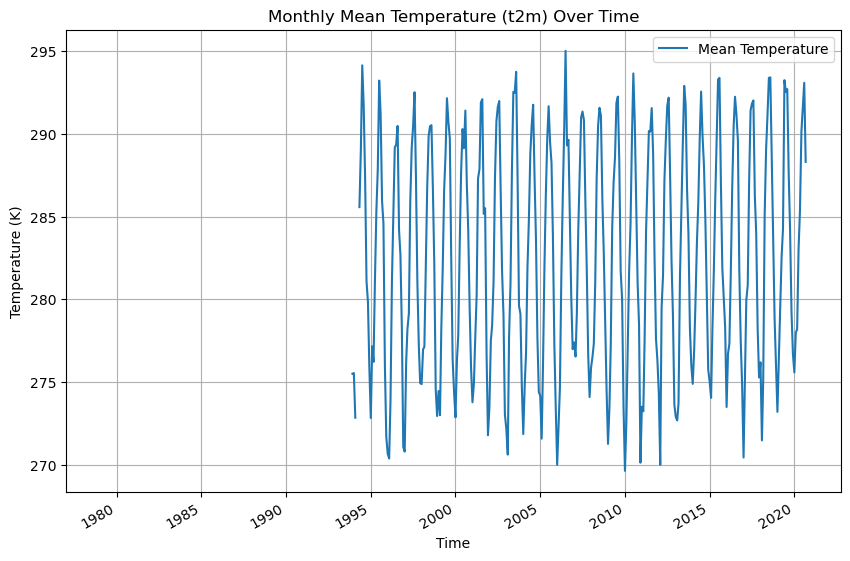

In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import geopandas as gpd
# 读取NetCDF文件
data_path = "G:\\workflow0822\\era5_full_data-20241216T113828Z-001\\era5_full_data\\complete_era5_data.nc"
ds = xr.open_dataset(data_path)

# 显示数据集的基本信息
print(ds)
# 选择温度数据 (t2m)
t2m = ds['t2m']

# 计算时间维度上的月均值
t2m_monthly = t2m.resample(valid_time='1MS').mean()

# 绘制温度的时间变化图
plt.figure(figsize=(10, 6))
t2m_monthly.mean(dim=('latitude', 'longitude')).plot(label='Mean Temperature')
plt.title('Monthly Mean Temperature (t2m) Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid(True)
plt.show()



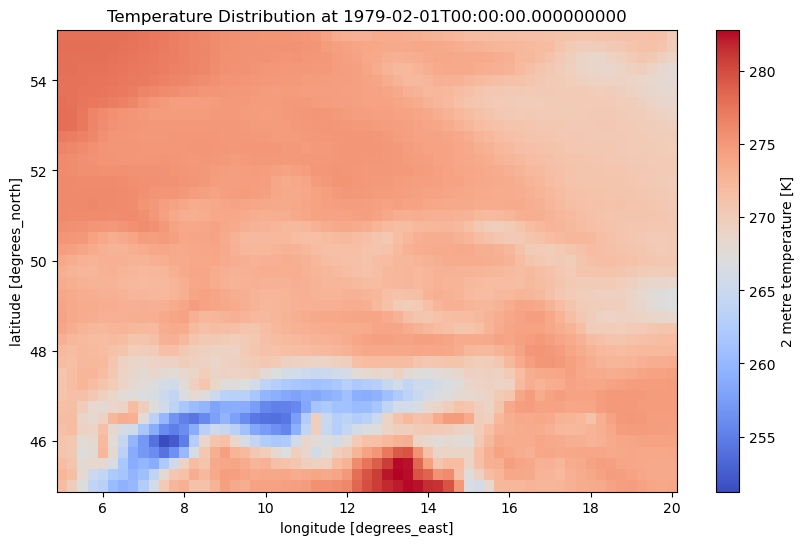

In [20]:
# 选择一个特定时间点的数据 (假设是第一个时间点)
time_point = ds['valid_time'].values[0]
t2m_at_time = t2m.sel(valid_time=time_point)

# 绘制该时间点的空间分布图
plt.figure(figsize=(10, 6))
t2m_at_time.plot(cmap='coolwarm')
plt.title(f'Temperature Distribution at {time_point}')
plt.show()


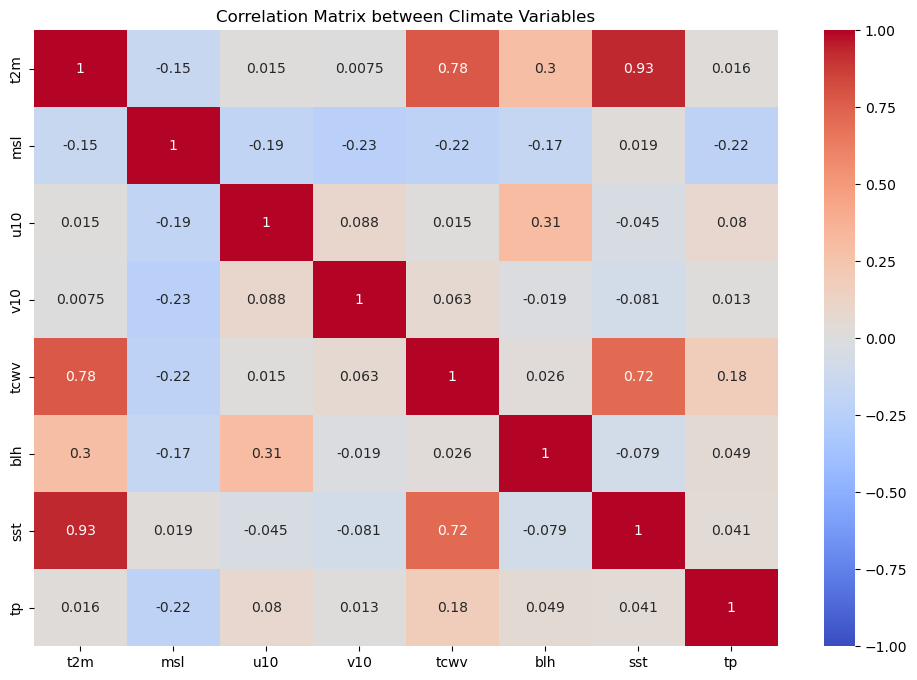

In [22]:
# 将需要的变量转换为 DataFrame 格式
# 假设我们需要 't2m' 和一些其他气候变量进行相关性分析
variables_of_interest = ['t2m', 'msl', 'u10', 'v10', 'tcwv', 'blh', 'sst', 'tp']

# 选择感兴趣的变量，并将其转换为 DataFrame
data_df = ds[variables_of_interest].to_dataframe().reset_index()

# 计算相关性矩阵
corr_matrix = data_df[variables_of_interest].corr()

# 绘制相关性矩阵
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Climate Variables')
plt.show()

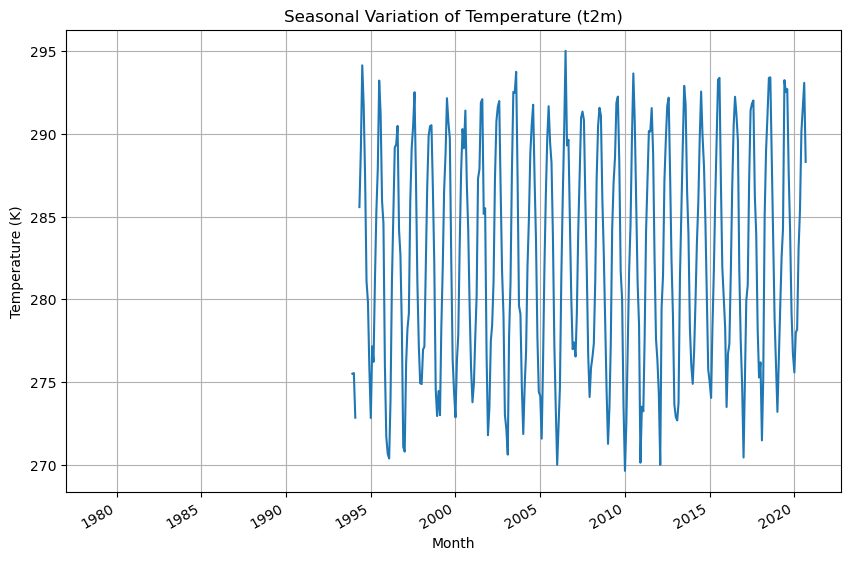

In [23]:
# 计算月度平均温度
t2m_monthly_mean = t2m.resample(valid_time='1MS').mean()

# 按月份绘制温度的季节性变化
monthly_avg = t2m_monthly_mean.mean(dim=('latitude', 'longitude'))
monthly_avg.plot(figsize=(10, 6))
plt.title('Seasonal Variation of Temperature (t2m)')
plt.xlabel('Month')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.show()


ValueError: the group variable's length does not match the length of this variable along its dimensions

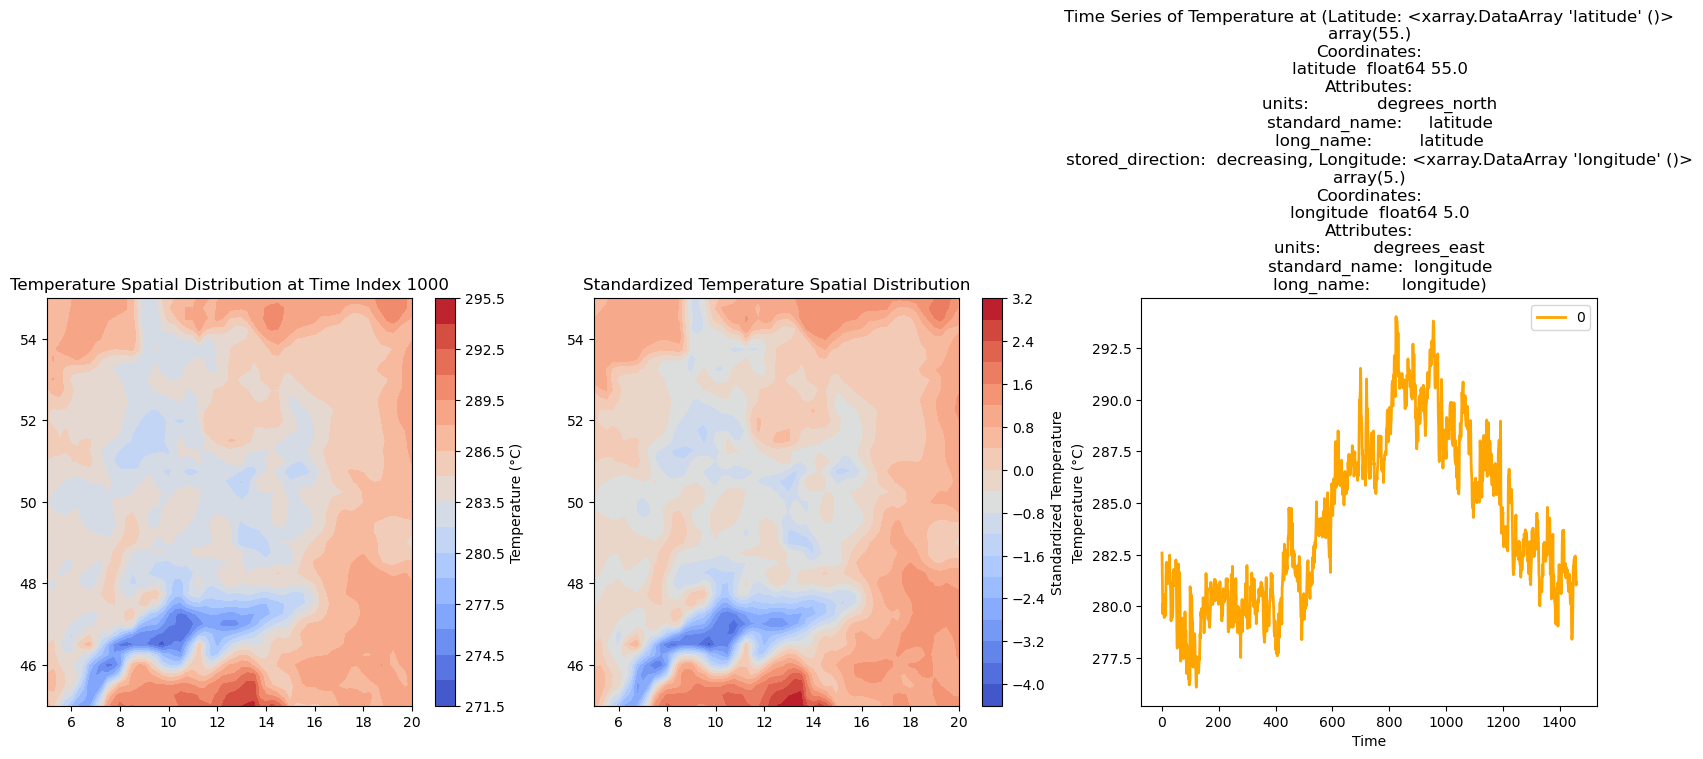

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

# 数据路径
data_path = "G:\\workflow0822\\era5_full_data-20241216T113828Z-001\\era5_full_data\\complete_era5_data.nc"

# 打开数据集
ds = xr.open_dataset(data_path)

# 选择温度变量
t2m = ds['t2m']

# 选择2019年的数据
t2m_2019 = t2m.sel(valid_time=slice("2019-01-01", "2019-12-31"))

# 随机截取一个时间点的数据
time_index = 1000  # 随机选择的时间索引
temperature_data = t2m_2019.isel(valid_time=time_index).values
latitude = ds['latitude'].values
longitude = ds['longitude'].values

# 数据处理：标准化
scaler = StandardScaler()
temperature_data_scaled = scaler.fit_transform(temperature_data.flatten().reshape(-1, 1)).reshape(temperature_data.shape)

# EDA可视化部分
def plot_temperature_eda_2019(t2m_2019, temperature_data_scaled, ds, time_index):
    plt.figure(figsize=(20, 18))

    # 1. 温度的空间分布热力图
    plt.subplot(3, 3, 1)
    lon, lat = np.meshgrid(ds['longitude'].values, ds['latitude'].values)
    heatmap_data = temperature_data
    plt.contourf(lon, lat, heatmap_data, cmap="coolwarm", levels=20)
    plt.title("Temperature Spatial Distribution at Time Index {}".format(time_index))
    plt.colorbar(label='Temperature (°C)')
    
    # 2. 标准化后的温度空间分布热力图
    plt.subplot(3, 3, 2)
    plt.contourf(lon, lat, temperature_data_scaled, cmap="coolwarm", levels=20)
    plt.title("Standardized Temperature Spatial Distribution")
    plt.colorbar(label='Standardized Temperature')
    
    # 3. 温度的时间序列
    plt.subplot(3, 3, 3)
    df_time_series = pd.DataFrame(t2m_2019.isel(latitude=0, longitude=0).values.flatten())
    df_time_series.plot(ax=plt.gca(), linewidth=2, color="orange")
    plt.title("Time Series of Temperature at (Latitude: {}, Longitude: {})".format(ds['latitude'][0], ds['longitude'][0]))
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")

    # 4. 每年的温度平均值
    df_yearly = t2m_2019.groupby(ds['year']).mean(dim="valid_time")
    plt.subplot(3, 3, 4)
    df_yearly.plot(ax=plt.gca(), linewidth=2)
    plt.title("Annual Average Temperature (2019)")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    
    # 5. 每月温度平均值
    df_monthly = t2m_2019.groupby(ds['month']).mean(dim="valid_time")
    plt.subplot(3, 3, 5)
    df_monthly.plot(ax=plt.gca(), linewidth=2)
    plt.title("Monthly Average Temperature (2019)")
    plt.xlabel("Month")
    plt.ylabel("Temperature (°C)")
    
    # 6. 温度的分布图
    plt.subplot(3, 3, 6)
    sns.histplot(temperature_data.flatten(), kde=True, color="dodgerblue")
    plt.title("Temperature Distribution in 2019")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Frequency")

    # 7. 温度的散点图矩阵
    df_temp = pd.DataFrame(t2m_2019.sel(valid_time=slice("2019-01-01", "2019-12-31")).values.flatten(), columns=['t2m'])
    sns.pairplot(df_temp, height=2.5, diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.subplot(3, 3, 7)
    plt.title("Pairplot of Temperature in 2019")
    
    # 8. 温度的PCA分析
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(temperature_data_scaled.reshape(-1, 1))
    plt.subplot(3, 3, 8)
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=pca_components[:, 0], cmap="viridis", s=20)
    plt.title("PCA of Temperature Data (2019)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    
    # 9. 温度的年度变化图
    plt.subplot(3, 3, 9)
    df_yearly_variation = t2m_2019.groupby(ds['year']).std(dim="valid_time")
    df_yearly_variation.plot(ax=plt.gca(), linewidth=2, color="green")
    plt.title("Annual Temperature Variation (2019)")
    plt.xlabel("Year")
    plt.ylabel("Temperature Variation (°C)")
    
    # 10. 温度的经纬度变化图
    plt.figure(figsize=(10, 7))
    lon, lat = np.meshgrid(ds['longitude'].values, ds['latitude'].values)
    plt.contourf(lon, lat, temperature_data, cmap='coolwarm', levels=20)
    plt.title("Temperature Distribution Across Latitude and Longitude (2019)")
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    plt.tight_layout()
    plt.show()

# 执行EDA可视化
plot_temperature_eda_2019(t2m_2019, temperature_data_scaled, ds, time_index)


机器学习主代码

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import shap
import lime
import lime.lime_tabular
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import joblib

# 数据路径
data_path = "G:\\workflow0822\\era5_full_data-20241216T113828Z-001\\era5_full_data\\complete_era5_data.nc"

# 打开数据集
ds = xr.open_dataset(data_path)

# 选择感兴趣的变量
variables_of_interest = ['t2m', 'msl', 'u10', 'v10', 'tcwv', 'blh', 'sst', 'tp']
target_variable = 't2m'  # 预测目标变量

# 数据预处理：将时间维度的变量转化为平面格式，并标准化
def preprocess_data(variables, target_variable, time_index=0):
    """预处理数据：选择变量并标准化"""
    # 获取变量数据并按行拼接
    X = np.stack([ds[var].isel(valid_time=time_index).values.flatten() for var in variables], axis=1)
    y = ds[target_variable].isel(valid_time=time_index).values.flatten()
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler

# 模型选择与训练：增强功能，支持多种模型
def train_model(X_train, y_train, model_type='random_forest', param_grid=None):
    """训练机器学习模型（支持随机森林、XGBoost、LightGBM等）"""
    
    # 根据传入的模型类型选择模型
    if model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'xgboost':
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    elif model_type == 'lightgbm':
        model = lgb.LGBMRegressor(objective='regression', random_state=42)
    
    # 如果传入了超参数网格，使用网格搜索
    if param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print("Best parameters from GridSearchCV:", grid_search.best_params_)
        return grid_search.best_estimator_
    
    # 训练模型
    model.fit(X_train, y_train)
    return model

# 模型评估：包括交叉验证
def evaluate_model(model, X_test, y_test, X_train, y_train):
    """评估模型：包括交叉验证、MAE、R2等"""
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-Validation MAE: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R2 Score: {r2}")
    
    return mae, r2, y_pred

# SHAP解释方法：全局和局部可解释性
def shap_explain(model, X_train, feature_names):
    """SHAP值解释模型（全局和局部）"""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # 全局解释：特征重要性
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")
    
    # 局部解释：选取特定样本
    shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train[0], feature_names=feature_names)

# LIME解释方法：局部可解释性
def lime_explain(model, X_train, y_train, feature_names):
    """LIME解释模型（局部）"""
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels=y_train, feature_names=feature_names, class_names=["target"], discretize_continuous=True)
    
    # 选择一个样本进行解释
    idx = 10  # 选择样本点进行LIME解释
    explanation = explainer.explain_instance(X_train[idx], model.predict)
    
    # 可视化LIME解释结果
    explanation.show_in_notebook(show_table=True, show_all=False)

# 执行完整分析
def perform_ml_analysis():
    """执行机器学习分析并解释模型"""
    # 选择时间索引进行分析
    time_index = 100  # 可以调整不同时间点的索引
    
    # 数据预处理：选取部分变量并标准化
    X_scaled, y, scaler = preprocess_data(variables_of_interest, target_variable, time_index)
    
    # 切分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # 超参数网格定义：为不同模型设置超参数调优
    param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
    param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 6, 10]}
    param_grid_lgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 6, 10]}
    
    # 选择模型并训练
    model_type = 'xgboost'  # 可以改成'random_forest'或'lightgbm'
    model = train_model(X_train, y_train, model_type=model_type, param_grid=param_grid_xgb)
    
    # 模型评估
    mae, r2, y_pred = evaluate_model(model, X_test, y_test, X_train, y_train)
    
    # SHAP解释
    shap_explain(model, X_train, variables_of_interest)
    
    # LIME解释
    lime_explain(model, X_train, y_train, variables_of_interest)
    
    return model, mae, r2, y_pred

# 执行机器学习分析
perform_ml_analysis()
